ref:

logistic regression implementation

https://github.com/yawen-d/Logistic-Regression-on-MNIST-with-NumPy-from-Scratch/blob/master/logistic_regression.py

12 Types of Neural Network Activation Functions: How to Choose?

https://www.v7labs.com/blog/neural-networks-activation-functions

cross entropy derivative

https://charlee.li/how-to-compute-the-derivative-of-softmax-and-cross-entropy/

Tinker With a Neural Network Right Here in Your Browser.
Don’t Worry, You Can’t Break It. We Promise.

http://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=1,1,1&seed=0.09086&showTestData=false&discretize=false&percTrainData=50&x=false&y=false&xTimesY=true&xSquared=false&ySquared=true&cosX=false&sinX=true&cosY=false&sinY=true&collectStats=false&problem=classification&initZero=false&hideText=false

convnetjs

https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html

optimizers

https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/

### handcoded softmax regression (slow)

5


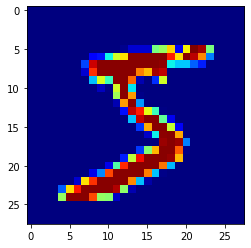

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mnist = fetch_openml('mnist_784')
x = mnist.data
y = mnist.target

x_np=x.to_numpy()
y_np=y.to_numpy()

plt.imshow(x_np[0,:].reshape(28,28),cmap='jet')
print(y_np[0])

0 0.7985971809714592
100 0.01605772260998989
200 0.008252246358611364
300 0.005575269979438197
400 0.004217010453898682
500 0.0033941285956163264
600 0.0028416267335031596
700 0.002444785165355318
800 0.00214580703828174
900 0.001912388081094504


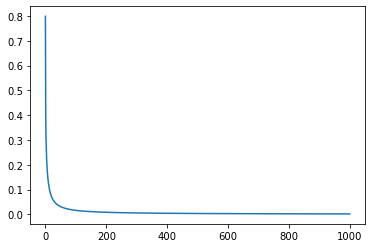

In [2]:
def one_hot(y):
    out=np.zeros((y.shape[0],10))
    for i in range(y.shape[0]):
        out[i][int(y[i])]=1
        
    return out

def softmax(h):
    
    out=np.ones_like(h)
    
    #number of datapoints:shape[0]
    for i in range(h.shape[0]):
        
        h_=np.exp(h[i]-h[i].max())
        out[i]=(1/np.sum(h_))*h_
        
    return out


def cross_entropy(X,Y,theta):
    
    h=softmax(X@theta)
    loss=0
    n_data=h.shape[0]
    n_label=h.shape[1]
    
    for i in range(n_data):
        
        loss-=np.log(h[i][int(np.where(Y[i]==1)[0][0])])
    return loss/n_data

    
def predict(X,theta):
    
    return np.argmax(softmax(X@theta),axis=1)

X=x_np[:600,:]
X=(X/X.max())
n_data=X.shape[0]#600
Y=y_np[:600]
X=np.hstack((np.ones((n_data,1)),X))
Y=one_hot(Y)

n_label=Y.shape[1]#10
n_weight=X.shape[1]#785

theta=np.random.randn(n_weight,n_label)/np.sqrt(n_weight*n_label)

thetas=[]
grads=[]
losses=[]
lr=0.01
N=1000

for i in range(N):
    loss=0
    for j in range(n_data):
        h=softmax(X[j,:].reshape(1,n_weight)@theta)  
        grad=(X[j,:].reshape(n_weight,1))@(h-Y[j].reshape(1,n_label))     
        theta=theta-lr*grad
        loss+=cross_entropy(X[j,:].reshape(1,n_weight),Y[j].reshape(1,n_label),theta)
    losses.append(loss/n_data)
    if i%100==0:
        print(i,loss/n_data)


plt.plot(losses)

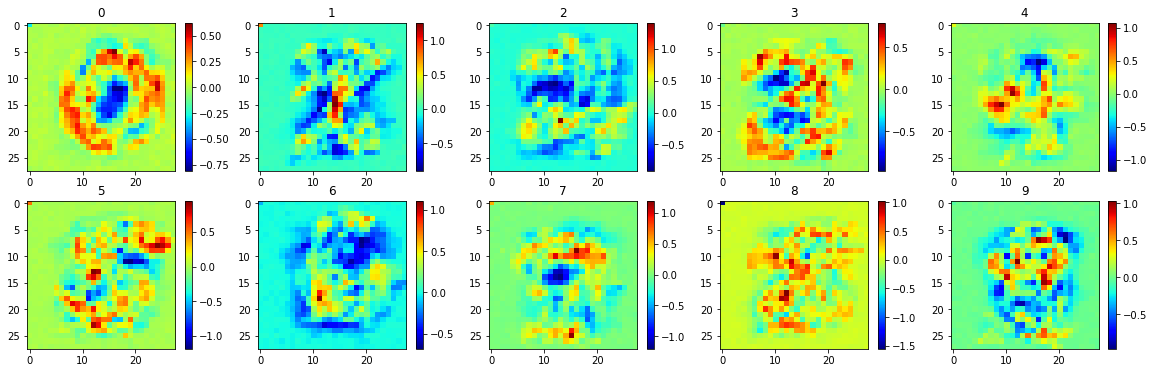

In [3]:
plt.figure(figsize=(20,6))
#axs=[]
for i in range(10):
    ax=plt.subplot(2,5,i+1)
    plt.imshow(theta[:-1,i].reshape(28,28),cmap='jet')
    plt.title(str(i))
    plt.colorbar()
#    axs.append(fig)
plt.savefig('mnist_softmax_weights.png',dpi=350)

### keras nn

In [4]:
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD,Adam,Adagrad,RMSprop

def preprocess_data(n_train=5000,n_test=1000):
    
    n_out=10

    (x_train,y_train),(x_test,y_test)=mnist.load_data()

    x_train=x_train/255.
    x_test=x_test/255.

    #one-hot encoding
    y_train = keras.utils.np_utils.to_categorical(y_train, n_out)
    y_test = keras.utils.np_utils.to_categorical(y_test, n_out)
    
    idx_train=np.random.randint(x_train.shape[0],size=n_train)
    idx_test=np.random.randint(x_test.shape[0],size=n_test)

    x_train=x_train[idx_train,:]
    y_train=y_train[idx_train]
    x_test=x_test[idx_test,:]
    y_test=y_test[idx_test]

    x_train=x_train.reshape((n_train,784))
    x_test=x_test.reshape((n_test,784))
    
    return x_train,y_train,x_test,y_test

def build_model(lr=0.1,n_hidden=[10],optimizer='sgd'):
    
    model=Sequential()
    if len(n_hidden)==1:
        model.add(Dense(n_hidden[0],input_dim=784,activation='softmax'))
    else:
        model.add(Dense(n_hidden[0],input_dim=784,activation='relu'))  
        for n in n_hidden[1:-1]:
            model.add(Dense(n,activation='relu'))
        
        model.add(Dense(n_hidden[-1],activation='softmax'))
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])

    
    return model
    
def train_model(x_train,y_train,x_test,y_test,model,n_iter=50,batch_size=32):
    
    traj=model.fit(x_train,
                   y_train,
                   epochs=n_iter,
                   batch_size=batch_size,
                   validation_data=(x_test, y_test),
                   verbose=0)
    
    return traj
    
def mnist_nn(lr=0.1,n_iter=50,batch_size=32,n_hidden=[],optimizer='sgd'):
    
    x_train,y_train,x_test,y_test=preprocess_data()
    model=build_model(lr=lr,n_hidden=n_hidden,optimizer=optimizer)
    traj=train_model(x_train,y_train,x_test,y_test,model,n_iter=n_iter,batch_size=batch_size)
    
    return traj

trajs={}
trajs['sgd']=mnist_nn(lr=0.1,n_iter=50,batch_size=32,n_hidden=[10],optimizer='sgd')
trajs['adam']=mnist_nn(lr=0.1,n_iter=50,batch_size=32,n_hidden=[10],optimizer='adam')
trajs['adagrad']=mnist_nn(lr=0.1,n_iter=50,batch_size=32,n_hidden=[10],optimizer='Adagrad')
trajs['rms']=mnist_nn(lr=0.1,n_iter=50,batch_size=32,n_hidden=[10],optimizer='RMSprop')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


2022-06-16 21:37:59.119969: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense

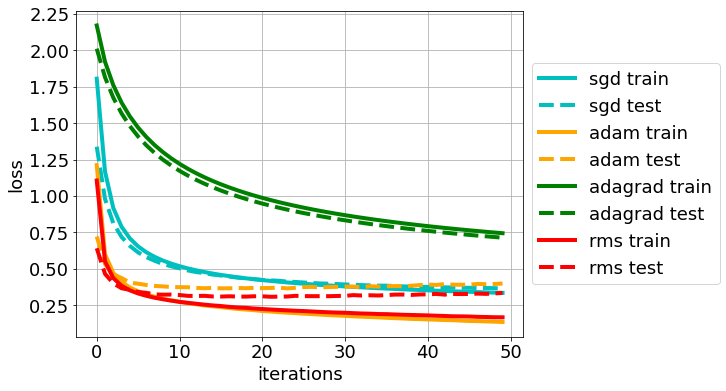

In [5]:
plt.rcParams['font.size']='18'
plt.figure(figsize=(8,6))
colors=['c','orange','g','r']
for i,(k,v) in enumerate(trajs.items()):
    plt.plot(v.history['loss'],color=colors[i],label=k+' train',linewidth=4)
    plt.plot(v.history['val_loss'],color=colors[i],linestyle='--',label=k+' test',linewidth=4)
    
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('iterations')
plt.ylabel('loss')
plt.grid()
plt.savefig('mnist_nn_opt_loss_compare.png',dpi=350,bbox_inches='tight')

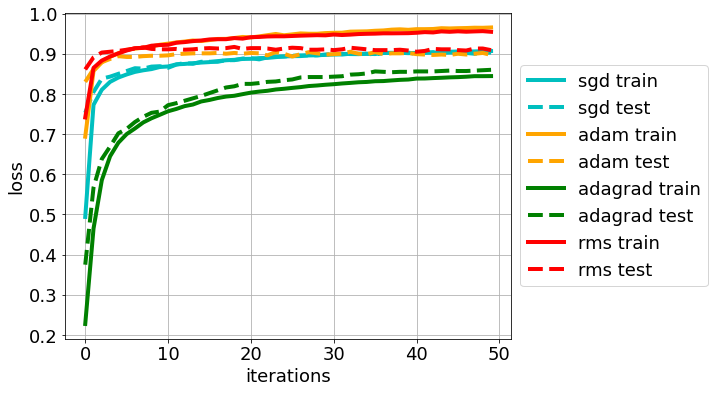

In [6]:
plt.rcParams['font.size']='18'
plt.figure(figsize=(8,6))
colors=['c','orange','g','r']
for i,(k,v) in enumerate(trajs.items()):
    plt.plot(v.history['categorical_accuracy'],color=colors[i],label=k+' train',linewidth=4)
    plt.plot(v.history['val_categorical_accuracy'],color=colors[i],linestyle='--',label=k+' test',linewidth=4)
    
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('iterations')
plt.ylabel('loss')
plt.grid()
plt.savefig('mnist_nn_opt_acc_compare.png',dpi=350,bbox_inches='tight')

In [7]:
trajs['l1_b32']=mnist_nn(lr=0.1,n_iter=50,batch_size=32,n_hidden=[10])
trajs['l1_b1']=mnist_nn(lr=0.1,n_iter=50,batch_size=1,n_hidden=[10])
trajs['l2_b32']=mnist_nn(lr=0.1,n_iter=50,batch_size=32,n_hidden=[10,10])
trajs['l2_b1']=mnist_nn(lr=0.1,n_iter=50,batch_size=1,n_hidden=[10,10])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense

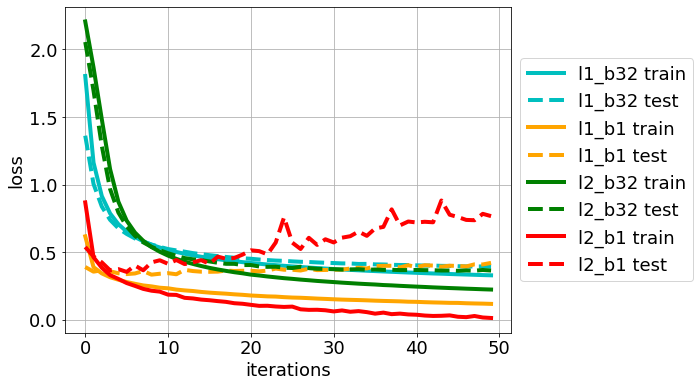

In [8]:
plt.rcParams['font.size']='18'
plt.figure(figsize=(8,6))
colors=['c','orange','g','r']

sub_trajs={k: trajs[k] for k in ('l1_b32', 'l1_b1', 'l2_b32','l2_b1')}

for i,(k,v) in enumerate(sub_trajs.items()):
    plt.plot(v.history['loss'],color=colors[i],label=k+' train',linewidth=4)
    plt.plot(v.history['val_loss'],color=colors[i],linestyle='--',label=k+' test',linewidth=4)
    
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('iterations')
plt.ylabel('loss')
plt.grid()
plt.savefig('mnist_nn_loss_compare.png',dpi=350,bbox_inches='tight')

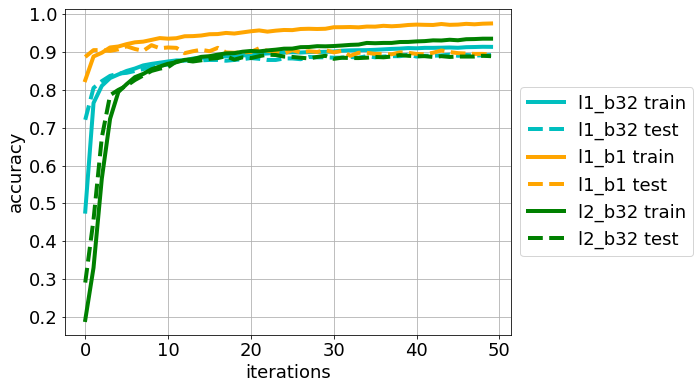

In [9]:
plt.figure(figsize=(8,6))

for i,(k,v) in enumerate(sub_trajs.items()):
    plt.plot(v.history['categorical_accuracy'],color=colors[i],label=k+' train',linewidth=4)
    plt.plot(v.history['val_categorical_accuracy'],color=colors[i],linestyle='--',label=k+' test',linewidth=4)
    if i==2:
        break
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.grid()
plt.savefig('mnist_nn_acc_compare.png',dpi=350,bbox_inches='tight')

### demo one layer

/Users/wang-j/miniforge3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


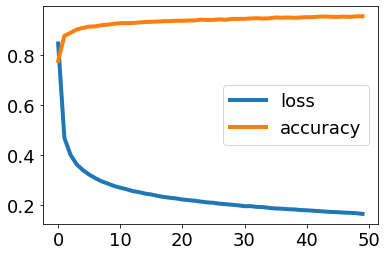

In [10]:
x_train,y_train,x_test,y_test=preprocess_data()

model=Sequential()
model.add(Dense(10,input_dim=784,activation='sigmoid'))##sigmoid also works, check! before was softmax
#model.add(Dense(10,activation='softmax'))
model.compile(optimizer=SGD(lr=0.1),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

traj=model.fit(x_train,
               y_train,
               epochs=50,
               batch_size=32,
               validation_data=(x_test, y_test),
               shuffle=True,verbose=0)

plt.plot(traj.history['loss'],linewidth=4,label='loss')
plt.plot(traj.history['categorical_accuracy'],linewidth=4,label='accuracy')
plt.legend()
plt.savefig('mnist_nn_single.png',dpi=350)

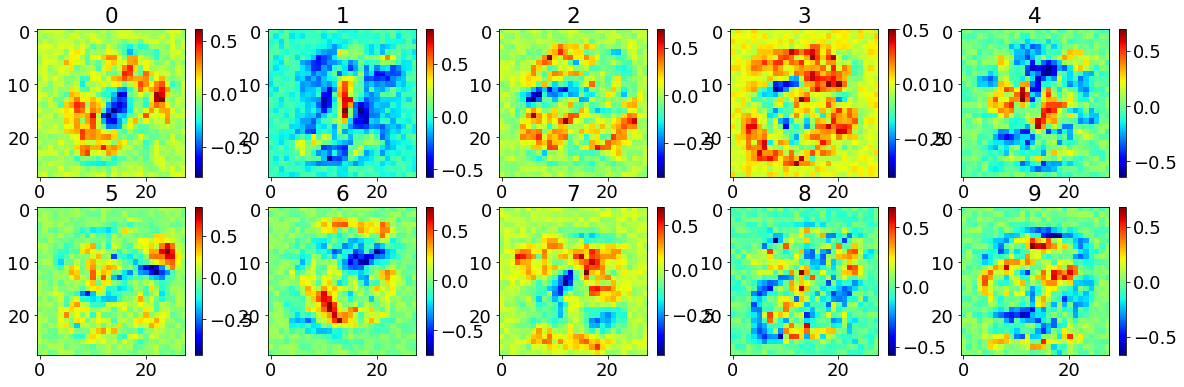

In [11]:
plt.figure(figsize=(20,6))
for i in range(10):
    ax=plt.subplot(2,5,i+1)
    plt.imshow(model.layers[0].get_weights()[0][:,i].reshape(28,28),cmap='jet')
    plt.title(str(i))
    plt.colorbar()
plt.savefig('mnist_nn_weights_1l.png',dpi=350)

### demo two layers

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 10)                7850      
                                                                 
 dense_12 (Dense)            (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


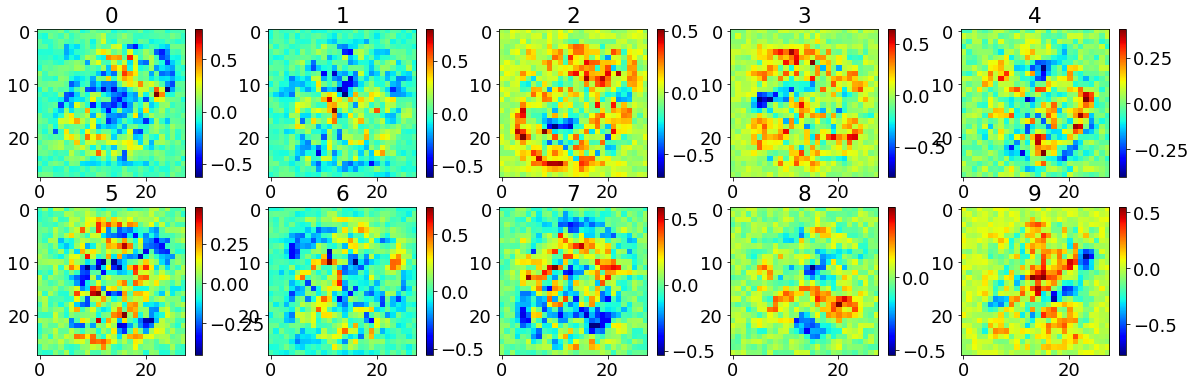

In [12]:
x_train,y_train,x_test,y_test=preprocess_data()

model=Sequential()
model.add(Dense(10,input_dim=784,activation='relu'))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=SGD(lr=0.1),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
traj=model.fit(x_train,
               y_train,
               epochs=50,
               batch_size=32,
               validation_data=(x_test, y_test),
               shuffle=True,verbose=0)
    
plt.figure(figsize=(20,6))

#axs=[]
for i in range(10):
    ax=plt.subplot(2,5,i+1)
    plt.imshow(model.layers[0].get_weights()[0][:,i].reshape(28,28),cmap='jet')
    plt.title(str(i))
    plt.colorbar()
plt.savefig('mnist_nn_weights_2l.png',dpi=350)

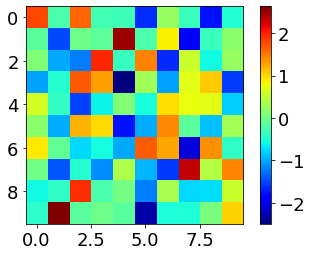

In [13]:
plt.imshow(model.layers[1].get_weights()[0],cmap='jet')
plt.colorbar()
plt.savefig('mnist_nn_weights_2l2.png',dpi=350)

### draw activation functions

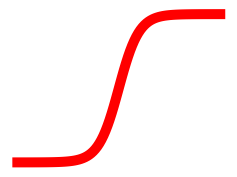

In [14]:
z=np.linspace(-10,10,num=100)
plt.figure(figsize=(4,3))
plt.plot(1/(1+np.exp(-z)),'r',linewidth=10)

plt.axis('off')
plt.savefig('sigmoid_nn.png',dpi=350)

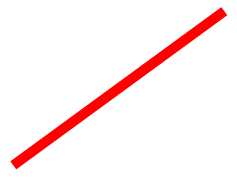

In [15]:
z=np.linspace(-10,10,num=100)
plt.figure(figsize=(4,3))
plt.plot(z,'r',linewidth=10)

plt.axis('off')
plt.savefig('linear_nn.png',dpi=350)

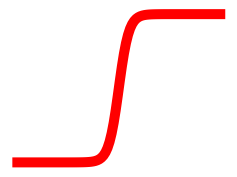

In [16]:
z=np.linspace(-10,10,num=100)
plt.figure(figsize=(4,3))
plt.plot((np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z)),'r',linewidth=10)

plt.axis('off')
plt.savefig('tanh_nn.png',dpi=350)

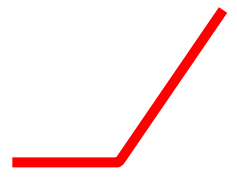

In [17]:
z=np.linspace(-10,10,num=100)
plt.figure(figsize=(4,3))
plt.plot((z>0)*z,'r',linewidth=10)

plt.axis('off')
plt.savefig('relu_nn.png',dpi=350)

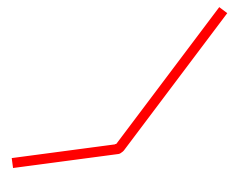

In [18]:
z=np.linspace(-10,10,num=100)
plt.figure(figsize=(4,3))
plt.plot(np.where(z > 0, z, z * 0.1),'r',linewidth=10)

plt.axis('off')
plt.savefig('leakyrelu_nn.png',dpi=350)
